# Prova de Sinais e sistemas

In [2]:
# Bibliotescas
using LinearAlgebra
using Pkg
using Plots
using Polynomials
gr()

Plots.GRBackend()

In [3]:
# Função de Runge-Kutta de quarta ordem para um único passo
function rk4_step(f, t, y, h)
    k1 = h * f(y, t)
    k2 = h * f(y .+ 0.5 .* k1, t + 0.5 * h)
    k3 = h * f(y .+ 0.5 .* k2, t + 0.5 * h)
    k4 = h * f(y .+ k3, t + h)
    y_next = y .+ (k1 .+ 2 .* k2 .+ 2 .* k3 .+ k4) / 6
    return y_next
end

# Função para o método de Runge-Kutta de quarta ordem adaptativo
function rk4_adaptive(f, t0, y0, t_end, h_init, tol)
    t = t0
    y = y0
    h = h_init
    ts = [Float64(t)]
    ys = [ComplexF64.(y)]
    
    while t < t_end
        # Garantir que o passo não exceda o ponto final
        if t + h > t_end
            h = t_end - t
        end

        # Executar um passo completo com passo h
        y_full = rk4_step(f, t, y, h)
        
        # Executar dois passos com passo h/2
        y_half = rk4_step(f, t, y, h / 2)
        y_half = rk4_step(f, t + h / 2, y_half, h / 2)
        
        # Estimar o erro local
        error = norm(y_full - y_half) / norm(y_half)
        
        if error <= tol
            # Aceitar o passo
            t += h
            y = y_half
            push!(ts, t)
            push!(ys, y)
        end
        
        # Ajustar o tamanho do passo
        h = h * min(2.0, max(0.1, 0.9 * (tol / error)^0.2))
    end
    
    # Converter ys para uma matriz 2D de ComplexF64
    y_m = hcat(ys...)
    
    return ts, y_m
end

# Método Runge-Kutta de quarta ordem
function rk4_4d(a, b, N, r0, f)
    h = (b - a) / N
    t = range(a, b, N)
    r = zeros(ComplexF64,2, N)
    r[:, 1] .= r0
    
    for i in 2:N

        k1 = h * f(r[:, i-1], t[i-1])
        k2 = h * f(r[:, i-1] + 0.5 * k1, t[i-1] + 0.5 * h)
        k3 = h * f(r[:, i-1] + 0.5 * k2, t[i-1] + 0.5 * h)
        k4 = h * f(r[:, i-1] + k3, t[i-1] + h)
        
        r[:, i] = r[:, i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    end
    
    return r
end

rk4_4d (generic function with 1 method)

In [4]:
# Minhas estrutura
struct Circ # Lembrar de usar o type array invez de matriz, e melhor
    # Matrizes do espaço dos estados
    A::Array{Complex{Float64}}
    B::Array{Complex{Float64}}
    C::Array{Complex{Float64}}
    D::Array{Complex{Float64}}

    # Constantes do sistema
    L::Float64
    R::Float64
    C_::Float64

    
    #iniciação do sistema
    function Circ(L::Float64, R::Float64, C_::Float64)
        A = [-1/(R*C_) 1/C_; -1/L 0]
        B = [0; 1/L]
        C = [1 0]
        D = [0.0] 
        new(A, B, C, D, L, R, C_)
    end
    
end


In [5]:
#Eq.diferencial do sistema
function f_z(R,t)
    X = func_x(t)
    Z = R
    dz = A*Z + B*X
    return dz
end

function func_y(Z,t)
    X = func_x.(t)
    y = C*Z + D*X
    return y
end

function func_x(t)
    return sin.(t)
end


func_x (generic function with 1 method)

In [38]:
# Caracteristicas do meu sistema
l = 1.0 
c = 1.0 
r = 1.0 * 1e3
sistema = Circ(l,r,c)

A = sistema.A
B = sistema.B
C = sistema.C
D = sistema.D


1-element Vector{ComplexF64}:
 0.0 + 0.0im

In [40]:
# Defina o polinômio do denominador
denominator_coeffs = [l*c, l/r, 1] # Coeficientes do denominador D(s) = s^2 + 3s + 2
denominator_poly = Polynomial(denominator_coeffs)
poles = roots(denominator_poly)

2-element Vector{ComplexF64}:
 -0.0004999999999999989 - 0.9999998749999922im
 -0.0004999999999999989 + 0.9999998749999922im

In [84]:
r0 = [10000,0]
r01 = (10,0)
a = 0
b = 1000
N = 10000
t = range(a,b,N)
z1 = rk4_4d(a, b, N, r0, f_z)
h_init = (b-a)/N
tol = 1e-6
ts,z = rk4_adaptive(f_z, a, r0, b, h_init, tol)
z1 = rk4_4d(a, b, N, r01, f_z)

2×10000 Matrix{ComplexF64}:
 10.0+0.0im    9.94921+0.0im  …  -261.544+0.0im  -231.754+0.0im
  0.0+0.0im  -0.993292+0.0im      285.025+0.0im    309.79+0.0im

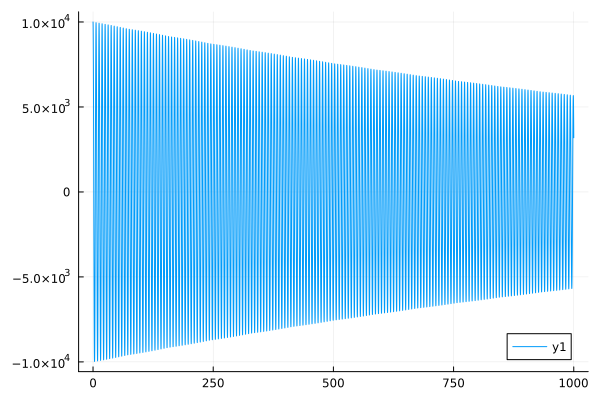

In [88]:
x = func_x(ts)
y = C*z + D*transpose(x)




plot(ts,real.(transpose(y)))



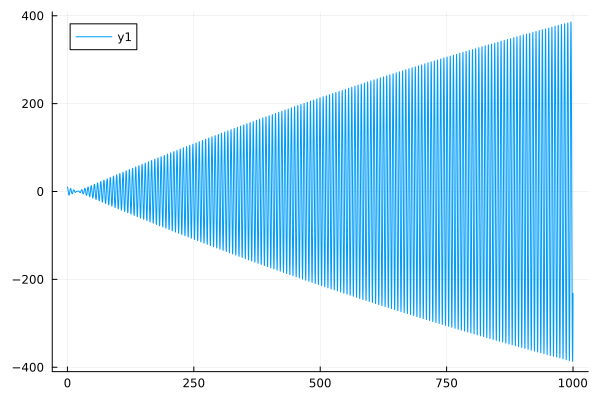

In [90]:
x_ = func_x(t)
y_ = C*z1 + D*transpose(x_)
plot(t,real.(transpose(y_)))